# Imports

In [1]:
import os
import tarfile
import jdc      #for class handling in jupyter
import numpy as np

# Part1

In [2]:
#!wget -N http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz

In [3]:
def read_tar():
    # open file 
    review_file = tarfile.open('review_polarity.tar.gz') 
  
    # extracting file 
    review_file.extractall('.') 
  
    review_file.close() 

In [4]:
"""_summary_
grab data from directory paths and lists
"""
def get_data(dir_list, dir_path, review_polarity):
  words = set()
  reviews = []
  sentiment = []
  
  for file_name in dir_list:
      if isinstance(file_name, str):
          f = open(os.path.join(dir_path, file_name),'r')
          review = f.read()
          reviews.append(review)
          words = words|set(review.split()) 
          sentiment.append(review_polarity)
          f.close()
  return np.array(reviews), np.array(sentiment), words

In [5]:
index_dict = {} #dictionary of words:index in bag of words vector
#read_tar()
neg_path = 'txt_sentoken/neg'
pos_path = 'txt_sentoken/pos'
neg_files = os.listdir(neg_path)
pos_files = os.listdir(pos_path)

neg_rev, neg_sent, neg_words = get_data(neg_files, neg_path, -1)
pos_rev, pos_sent, pos_words = get_data(pos_files, pos_path, 1)
#form word bag, X_raw, and prediction sets
words = neg_words|pos_words
X_raw = np.concatenate((neg_rev,pos_rev),axis=0)
y_raw = np.concatenate((neg_sent,pos_sent),axis=0)
sorted_words = sorted(words)

In [6]:
#shuffles both predictions and raw data with same permutation.
def shuffle(data, labels):
    p = np.random.permutation(len(data))
    return data[p], labels[p], p

In [7]:
X_shuffled, y_shuffled, p = shuffle(X_raw, y_raw)

In [8]:
print(p[:8],y_shuffled[:8], y_raw[p[:8]]) #could just be asserts i guess
print(X_shuffled[:8] == X_raw[p[:8]])

[1630 1290 1119  465 1906  693 1321 1279] [ 1  1  1 -1  1 -1  1  1] [ 1  1  1 -1  1 -1  1  1]
[ True  True  True  True  True  True  True  True]


In [9]:
print(X_shuffled[0][:10])

it was a c


In [10]:
X_shuffled.shape

(2000,)

dimensions look good! now to move onto implementing BOW

# Part2


In [11]:
"""_summary_
transform x into a sparse BoW array. implementation part 2
"""
class Vectorizer:
  def __init__(self, sorted_vocab, tokenizer = 'none'):
    self.tokenizer = tokenizer
    self.index_dict = dict()
    for i, word in enumerate(sorted_vocab):
      self.index_dict[word] = i
  
  def transform(self, data):
    sparse_data = []
    for review in data:
      review_list = review.split()              #replace with tokenizer if needed
      sparse_review = np.zeros(len(self.index_dict))
      for word in review_list:
          sparse_review[self.index_dict[word]] = 1
      sparse_data.append(sparse_review)
            
    assert len(data) == len(sparse_data)        #is the output array the same length as input?
    assert sum(sparse_data[0]) != 0             #do these sparse arrays contain anything?
    
    return np.array(sparse_data)

In [12]:
victor = Vectorizer(sorted_words)

In [13]:
index_dict = dict()
for i, word in enumerate(sorted_words):
  index_dict[word] = i

for word in ['dolphin', 'the', 'coffee']:
  if word in sorted_words:
    print("'%s' is represented as feature dimension %i" %(word, index_dict[word]))
  else:
    print("'%s' is not in the vocabulary" % word)

'dolphin' is represented as feature dimension 13868
'the' is represented as feature dimension 45372
'coffee' is represented as feature dimension 9677


In [14]:
X_BOW = victor.transform(X_shuffled)            #output should be bag of words rep of sentence

In [15]:
X_BOW[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [16]:
X_BOW.shape

(2000, 50920)

# Part3
**Implementation task:** You should implement your versions of the following parts (you can also find this in the slides):

In [17]:
class model:
  def __init__(self, eta0 = 0.001, loss = 'hinge', alpha = .0001, learning_rate = "constant", penalty = 'L2', random_state = 'none',
               tol = 5):
    
    self.loss = loss  #hinge loss default probably won't try others
    self.loss_history = []
    self.lr, self.eta0 = eta0, eta0  #starting learning rate
    self.alpha = alpha #regularization dampener
    self.learning_rate = learning_rate  #constant learning rate or schedule?
    self.penalty = penalty #penalty for hinge loss probably won't play with this
    self.tol = tol  #tolerance of learning rate scheduler if i ever get around to implementing that
    self.n_max_iterations = 100
    
  def fit(self, X, y):
    """Does the training. X is a matrix with one data point per row, while y is flat."""
    self.weights = np.random.normal(loc=0,scale=.5,size=X.shape[1])
    
    self.weight_history = [self.weights.copy()]
    best_score = self.score(X,y)
    self.loss_history = [best_score]
    iter_wo_improve = 0
    
    for i in range(self.n_max_iterations):
      self._fit(X,y)
      if best_score-.001 < self.loss_history[-1]: #if the new theta isn't better than last, then increment iter_wo_improve.
        iter_wo_improve += 1
      else:
        best_score = self.loss_history[-1]
        iter_wo_improve = 0
      if iter_wo_improve >= self.tol: #stop criterion
        return self.weight_history[-iter_wo_improve], self.loss_history[-iter_wo_improve] , i
      
    return self.weight_history[-1], self.loss_history[-1] , i #if max iterations is reached
      
  """gradient descent
  calculate vector of greatest slope and mod weights."""
  def _fit(self, X, y):
    #dot = X.dot(self.weights)
    #mult = X*self.weights
    #cond = np.sign(mult==y)
    #fred_sum = np.sum(np.sign(X.dot(self.weights))==y[:,np.newaxis],axis=0) #fredrick's suggestion. I don't quite get this.
    #my version: for each review, sum -y_i*X_i if 1-y_i*w.dot(X_i)<0 
    #sign is 1 if y*X.dot(w) < 1, so if we axe everything 1 or above with max, 
    sign_term = np.sign(np.maximum(0,1-y*X.dot(self.weights)))[:,np.newaxis]
    grad_per_review = -y[:,np.newaxis]*X*sign_term
    grad_sum = np.sum(grad_per_review,axis=0)   #sum across reviews for aggregate weight gradients
    """
    grad_sum_me = np.zeros_like(self.weights)
    for sentiment, review in zip(y,X):
      for i in range(len(review)):
        if sentiment*self.weights[i]*review[i]<1:
          grad_sum_me[i] -= review[i]*sentiment
    so slow to do it this way, but drastically different results
    """ 
    gradient = self.alpha*self.weights + grad_sum
    
    self.weights -= self.lr*gradient
    
    self.loss_history.append(self.score(X,y))
    self.weight_history.append(self.weights.copy())
    
  """hyperplane"""
  def predict(self, X):
    sgns = np.sign(X.dot(self.weights))  #signs for testing visibility
    return np.sign(X.dot(self.weights))

  #def _soft_predict(self, X):
  #  pred = X*self.weights
  #  return pred
  
  """hinge loss. output loss vector for... weights or reviews?"""
  def score(self, X, y):
    norm_term = self.alpha/2*np.linalg.norm(self.weights)**2
    #sum_term = np.sum(np.maximum(0,1-self.weights*X*y[:,np.newaxis],),axis=0)
    sum_term = np.sum(np.maximum(0,1-y*X.dot(self.weights))) #sum across reviews
    return norm_term + sum_term
  

In [24]:
reguliser_dampening = 0.0001   # lambda
learning_rate = 0.001         # gamma
X_BOW_intc = np.concatenate((np.ones_like(y_shuffled)[:,np.newaxis],X_BOW),axis=1) #intercept array

# Create the untrained classifier
classy = model(loss='hinge', penalty='l2',
                      alpha=reguliser_dampening,
                      learning_rate='constant', eta0=learning_rate)

# Train the classifier
best_weight, best_loss, iter = classy.fit(X_BOW_intc, y_shuffled)

# Get the parameter vector
omega = best_weight

In [18]:
#test cell
#why = y_shuffled.copy()
#eks = np.concatenate((np.ones_like(y)[:,np.newaxis],X_BOW),axis=1)
#w8s = np.random.normal(loc=0,scale=.5,size=eks.shape[1])
#print(why.shape, eks.shape, w8s.shape)

(2000,) (2000, 50921) (50921,)


In [19]:
sign_term = np.sign(np.maximum(0,1-why*eks.dot(w8s)))[:,np.newaxis]

In [20]:
gpreview = -why[:,np.newaxis]*eks*sign_term

In [23]:
np.sum(gpreview,axis=0).shape

(50921,)

In [19]:
(why[:,np.newaxis]*eks).shape

(2000, 50921)

In [25]:
np.maximum(0,1-why*eks.dot(w8s)).shape

(2000,)

In [40]:
np.sum(np.maximum(0,1-why*eks.dot(w8s)))

7710.9113084460905

In [20]:
training_accuracy = np.sum(classy.predict(X_BOW_intc)==y_shuffled)/len(y_shuffled)
training_accuracy

0.5015

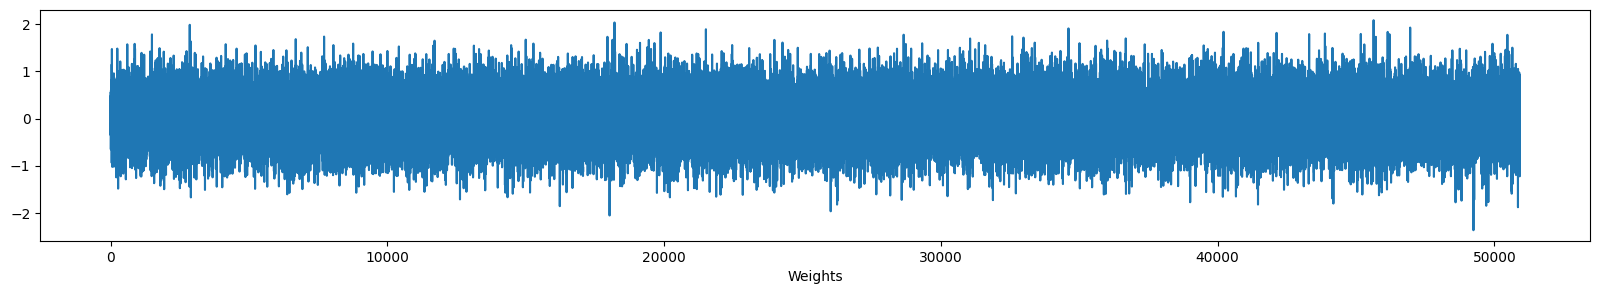

In [22]:
import matplotlib.pyplot as plt
 
plt.figure(figsize=(20, 3))
plt.plot(np.random.normal(loc=0,scale=.5,size=X_BOW.shape[1]))
plt.xlabel("Value")
plt.xlabel("Weights")
plt.show()

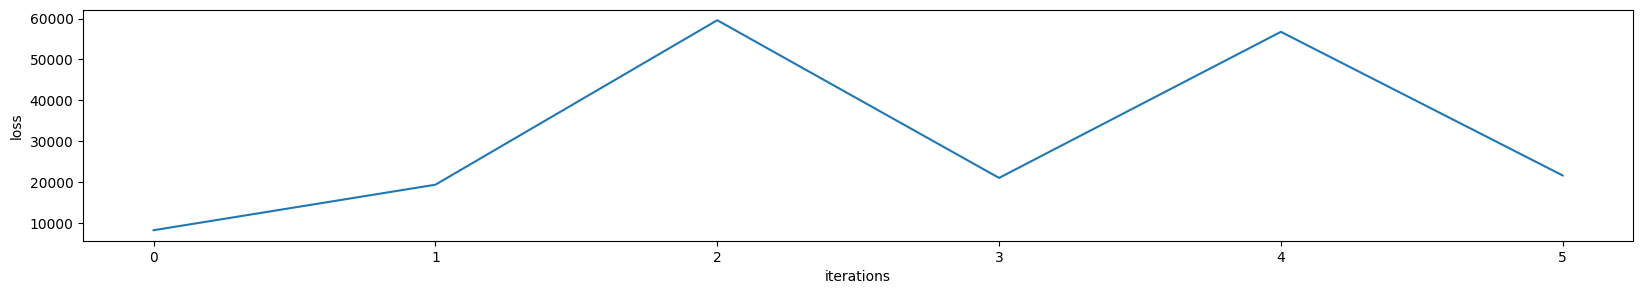

In [23]:
plt.figure(figsize=(20, 3))
plt.plot(classy.loss_history)
plt.ylabel("loss")
plt.xlabel("iterations")
plt.show()

In [24]:
assert (len(omega)-1) == len(sorted_words)

# Sort by absolute value
idx = np.argsort(np.abs(omega[1:]))

print("                Word   Weight  Occurences")
for i in idx[-20:]:   # Pick those with highest 'voting' values
  print("%20s   %.3f\t%i " % (sorted_words[i], omega[i+1], np.sum([sorted_words[i] in d for d in X_raw])))

                Word   Weight  Occurences
                   (   -1.793	1900 
                  on   -1.805	2000 
                than   -1.810	1389 
               looks   -1.814	364 
               would   -1.853	1189 
                  by   -1.859	1815 
                 out   -1.868	1925 
              script   -1.872	632 
                then   -1.913	892 
                 why   -1.914	586 
                even   -1.964	1521 
                have   -2.008	1658 
             there's   -2.049	617 
                when   -2.168	1459 
            director   -2.296	962 
                  if   -2.347	1872 
                  no   -2.360	1985 
                only   -2.464	1311 
                   ?   -2.742	1228 
                 bad   -3.337	825 


# Part4
**Implementation task:** Implement code for printing a sorted table of your sampled hyperparameters. Note, you do not have to reimplement the grid search.

In [ ]:
#split training and test data 80:20. they're already shuffled so just slice em.
proportion = .8

X_train = X_BOW_intc[:len(X_BOW_intc)*proportion]
X_test = X_BOW_intc[len(X_BOW_intc)*proportion:]

y_train = y_shuffled[:len(y)*proportion]
X_test = y_shuffled[len(y)*proportion:]

In [ ]:
from sklearn.model_selection import ParameterSampler

# Define the parameters
parameter_distribution = {'learning_rate': np.exp(np.linspace(np.log(0.0001), np.log(3), 10)),
                          'reguliser_dampening': np.exp(np.linspace(np.log(0.0001), np.log(3), 10))}

# Placeholder to make future comparissons easier
best_hyperparameters = None
print("Learning rate:\tReg.dampening:\tTraining set accuracy:")

for hyperparameters in ParameterSampler(parameter_distribution, n_iter=10):
  # Set up the classifier
  reguliser_dampening = hyperparameters['reguliser_dampening']
  learning_rate = hyperparameters['learning_rate']
  model = model(loss='hinge', penalty='l2',
                        alpha=reguliser_dampening,
                        learning_rate='constant', eta0=learning_rate)

  # Train the classifier
  model.fit(X_train, y_train)

  # Calculate the training accuracy    
  training_accuracy = np.sum(model.predict(X_train)==y_train)/len(y_train)

  # Store the hyperparameters if they are better than what we have found before
  if best_hyperparameters is None or best_hyperparameters[1] < training_accuracy:
    best_hyperparameters = (hyperparameters, training_accuracy)
  print("%.5f\t\t%.5f\t\t%.1f%%" % (hyperparameters['learning_rate'], hyperparameters['reguliser_dampening'], 100*training_accuracy))

best_learning_rate = best_hyperparameters[0]['learning_rate']
best_reguliser_dampening = best_hyperparameters[0]['reguliser_dampening']
print("Best parameters: %.5f, %.5f" % (best_learning_rate, best_reguliser_dampening))

Learning rate:	Reg.dampening:	Training set accuracy:
0.30353		0.30353		54.1%
0.00031		0.00031		95.8%
0.09655		0.09655		64.5%
0.30353		0.09655		65.4%
0.00031		0.00311		95.8%
0.00099		3.00000		84.5%
0.00311		3.00000		53.9%
0.00311		0.03071		94.9%
0.00311		0.09655		86.9%
0.00031		0.30353		85.9%
Best parameters: 0.00031, 0.00031
